# 구축된 MarketDB 사용하기

- From : https://github.com/INVESTAR/StockAnalysisInPython
- 소스 수정 필요
    + pymysql client 접속시 유저정보 수정
    + request 시 user-agent 정보 추가

In [1]:
import os, sys

sys.path.append("../source")

from Investar import Analyzer

In [2]:
mk = Analyzer.MarketDB()

In [3]:
mk.get_daily_price('조아제약', '2019-01-01', '2020-12-31')

,code,date,open,high,low,close,diff,volume
date,,,,,,,,
2019-01-02,034940,2019-01-02,4415,4425,4340,4360,5,87974
2019-01-03,034940,2019-01-03,4325,4390,4225,4240,120,121808
2019-01-04,034940,2019-01-04,4240,4340,4150,4335,95,117988
2019-01-07,034940,2019-01-07,4395,4415,4355,4380,45,90166
2019-01-08,034940,2019-01-08,4380,4620,4340,4580,200,317109
...,...,...,...,...,...,...,...,...
2020-12-23,034940,2020-12-23,5580,5850,5150,5150,400,8059083
2020-12-24,034940,2020-12-24,5200,5260,5040,5050,100,1118424
2020-12-28,034940,2020-12-28,5060,5110,4805,4825,225,1177366


In [4]:
del mk

# 트레이딩 전략과 구현

- 트레이딩 목적 : 가격 변화 예측을 통한 수익 창출
- 여러 트레이딩 전략을 파이썬으로 직접 구현 및 자신에게 맞는 전략을 찾아본다.

## 현대 포트폴리오 이론

- 해리 맥스 마코위츠의 1952년 논문 : `portfolio selection` 의 `mean-variance optimization`
- 예상 수익률과 리스크의 상관관계를 활용해 포트폴리오를 최적화하는 기법이다.
- 1990년 현대 포트폴리오 이론(modern portfolio theory, MPT)

### 수익률의 표준편차

- 수익률의 표준편차는 자산 가격이 평균값에서 벗어나는 정도(=리스크)를 측정하는 방법이다.
- 주가의 변동성을 의미한다.
- 수익률은 정규분포를 따른다고 가정한다.
    + 예상수익률은 평균값으로 구한다.
    + 수익률 표준편차는 (수익률 - 평균값)(=편차)의 제곱의 평균에 제곱근을 취해 구한다.
- 예) 예상수익률(평균값)이 7%, 수익률 표준편차가 5%인 주식 -> 2 ~ 12% 사이의 수익을 낼 확률이 68.3% 가 된다.

### 효율적 투자선

- 효율적 투자선이란 현대 포트폴리오 이론의 핵심 개념으로서, 투자자가 인내할 수 있는 리스크 수준에서 최상의 기대수익률을 제공하는 포트폴리오들의 집합을 나타낸다.
- X축: 리스크(표준편차), Y축: 예상수익률(평균)
- 효율적 투자선 위에 위차한 포트폴리오는 주어진 리스크에서 최대 수익을 나타낸다.

- 시총 상위 4종목으로 효율적 투자선 구하기
    + 2021년 현재 KOSPI 시가총액 1 ~ 4위까지 해당하는 종목으로 포트폴리오를 구성한다고 가정하고 효율적 투자선을 구해본다.
    + 교재에서는 2019년 기준으로 액면분할의 영향을 피하기 위해 2016년 1월 4일부터 2018년 4월 27일까지로 지정했다.
    + 해당 노트북에서는 액면분할 이후 일자인 2019년 1월 2일부터 2021년 6월 30일까지로 지정했다.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Investar import Analyzer

In [6]:
mk = Analyzer.MarketDB()
stocks = ['삼성전자', 'SK하이닉스', 'NAVER', '삼성바이오로직스'] # 2021년 10월 3일 기준 시총 상위 4종목
df = pd.DataFrame()
for s in stocks:
    df[s] = mk.get_daily_price(s, '2019-01-02', '2021-06-30')['close']

In [7]:
df

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
date,,,,
2019-01-02,38750,60600,118000,374000
2019-01-03,37600,57700,122000,376500
2019-01-04,37450,58300,125500,381000
2019-01-07,38750,58700,131500,388000
2019-01-08,38100,59200,130000,386000
...,...,...,...,...
2021-06-24,81200,126000,419500,855000
2021-06-25,81600,128500,410000,849000
2021-06-28,81900,126000,408000,843000


- 617개의 행을 갖는다.
- 위 데이터를 토대로 종목별로 일간 수익률, 연간 수익률, 일간 리스크, 연간 리스크를 구한다.

In [8]:
from datetime import datetime

In [9]:
daily_ret = df.pct_change()
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252

In [10]:
daily_ret

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.029677,-0.047855,0.033898,0.006684
2019-01-04,-0.003989,0.010399,0.028689,0.011952
2019-01-07,0.034713,0.006861,0.047809,0.018373
2019-01-08,-0.016774,0.008518,-0.011407,-0.005155
...,...,...,...,...
2021-06-24,0.013733,0.016129,-0.009445,-0.002334
2021-06-25,0.004926,0.019841,-0.022646,-0.007018
2021-06-28,0.003676,-0.019455,-0.004878,-0.007067


In [11]:
annual_ret

삼성전자        0.338185
SK하이닉스      0.378392
NAVER       0.582984
삼성바이오로직스    0.413582
dtype: float64

In [12]:
daily_cov

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
삼성전자,0.000303,0.000305,0.000124,0.000125
SK하이닉스,0.000305,0.000592,0.000167,0.000119
NAVER,0.000124,0.000167,0.000528,0.000133
삼성바이오로직스,0.000125,0.000119,0.000133,0.000664


In [13]:
annual_cov

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
삼성전자,0.076362,0.076839,0.031200,0.031577
SK하이닉스,0.076839,0.149260,0.042191,0.029915
NAVER,0.031200,0.042191,0.132958,0.033501
삼성바이오로직스,0.031577,0.029915,0.033501,0.167439


- 시총 상위 4종목 비중을 다르게 해 포트폴리오 20,000개를 생성한다.
- 포트폴리오 수익률, 리스크, 종목 비중을 저장할 각 리스트를 생성한다.

### 몬테카를로 시뮬레이션

- 20,000개의 포트폴리오를 생성하기 위해 넘파이 random() 함수를 사용해 각 포트폴리오에 포함된 4 종목의 비중을 모두 다르게 한다.
- 이처럼 매우 많은 난수를 이용해 함수의 값을 확률적으로 계산하는 것을 몬테카를로 시뮬레이션 이라고 한다.

In [14]:
from joblib import Parallel, delayed

In [15]:
port_ret = []
port_risk = []
port_weights = []
sharpe_ratio = []

In [16]:
def mc_sim_portfolio(num_stocks, annual_ret, annual_cov):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)

    returns = np.dot(weights, annual_ret)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    
    sharpe_ratio = returns / risk
    
    return returns, risk, weights, sharpe_ratio

In [17]:
num_portfolio = 20000
results = Parallel(n_jobs=4)(delayed(mc_sim_portfolio)(len(stocks), annual_ret, annual_cov) for _ in range(num_portfolio))

In [18]:
for ret, risk, weight, s_r in results:
    port_ret.append(ret)
    port_risk.append(risk)
    port_weights.append(weight)
    sharpe_ratio.append(s_r)

In [19]:
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}

In [20]:
for i, s in enumerate(stocks):
    portfolio[s] = [weight[i] for weight in port_weights]

In [21]:
df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk', 'Sharpe'] + [s for s in stocks]] 

In [22]:
df

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
0,0.402961,0.245857,1.639008,0.436988,0.132397,0.159298,0.271317
1,0.403216,0.289859,1.391075,0.056893,0.448071,0.057208,0.437828
2,0.416809,0.258669,1.611362,0.237193,0.223649,0.171079,0.368078
3,0.397811,0.272270,1.461091,0.368545,0.052474,0.081834,0.497147
4,0.502747,0.280137,1.794648,0.064637,0.184434,0.593429,0.157500
...,...,...,...,...,...,...,...
19995,0.445605,0.262203,1.699470,0.263447,0.295924,0.367764,0.072866
19996,0.443217,0.264666,1.674626,0.257142,0.321917,0.356261,0.064680
19997,0.399036,0.251090,1.589216,0.444553,0.232289,0.160249,0.162909
19998,0.438972,0.262253,1.673849,0.115582,0.336643,0.271253,0.276521


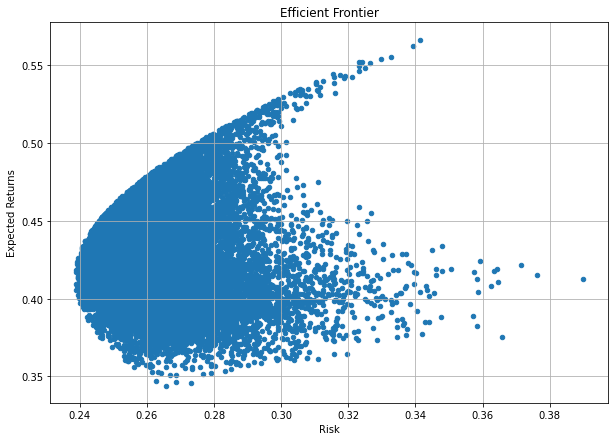

In [23]:
df.plot.scatter(x='Risk', y='Returns', figsize=(10, 7), grid=True)
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

## 샤프 지수와 포트폴리오 최적화

- 현대 포트폴리오 이론에 따르면 개별 리스크가 주어졌을때 효율적 투자선보다 높은 수익률은 기대할 수 없다.
- 리스크를 최소화하고 수익률은 최대화하는 포트폴리오는 어떻게 찾아낼 수 있을까?
    + 해리 마코위츠의 초기 이론만으로는 이를 해결하기 힘들다.
- 샤프 지수(Sharpe Ratio)는 현대 포트폴리오 이론에서 매우 중요하다.
    + 측정된 위험 단위당 수익률을 계산한다는 점에서 수익률의 표준편차와 다른 점이 있다.
    + $ 샤프지수 = \frac{포트폴리오 예상수익률 - 무위험률}{수익률의 표준편차}$
- 교재에서는 계산의 편의를 고려해 무위험률을 0으로 가정했으며, 샤프지수는 포트폴리오의 예상수익률을 수익률의 표준편차로 나누어서 구했다.
- 샤프지수가 높을수록 리스크에 대한 보상이 더 크다.
- 해당 지수는 이전 섹션에서 이미 계산하여 추가했다.

- 포트폴리오 최적화
    + KOSPI 시총 상위 4개 종목이 각각 랜덤한 비율로 구성된 20,000개 포트폴리오 중에서 단순히 예상 수익률이 가장 높은 포트폴리오를 구해도 된다.
    + 여기서는 샤프 지수를 이용하여, 측정된 위험 단위당 수익이 제일 높은 포트폴리오를 구하도록 한다.

In [24]:
max_sharpe = df.loc[df['Sharpe'].argmax()]

- 리스크 컬럼에서 리스크값이 제일 작은 행을 min_risk로 정한다.

In [26]:
min_risk = df.loc[df['Risk'].argmin()]

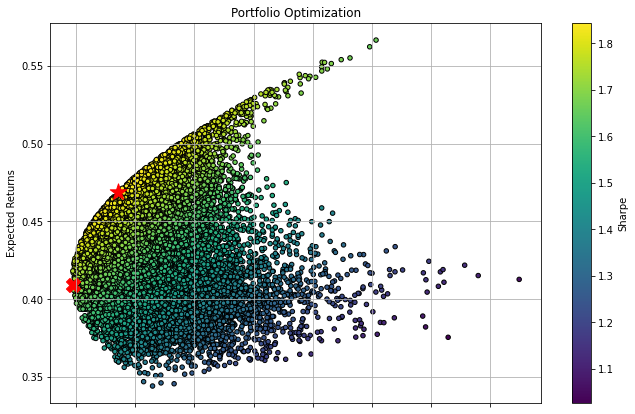

In [27]:
df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis',
               edgecolors='k', figsize=(11, 7), grid=True)
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker='*', s=300)
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r', marker='X', s=200)
plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [28]:
max_sharpe

Returns     0.468835
Risk        0.254249
Sharpe      1.843998
삼성전자        0.337567
SK하이닉스      0.015406
NAVER       0.479609
삼성바이오로직스    0.167418
Name: 3663, dtype: float64

- 별표 : 리스크당 수익률이 가장 큰 포트폴리오
- 3,663번째 행에 해당
- 1년 반 동안 25%의 변동률을 겪으면서 46.8%의 수익을 안겼다.
- 종목별 비중을 살펴보면 `NAVER` 비율이 47.9%로 제일 높았다.

In [29]:
min_risk

Returns     0.409143
Risk        0.238813
Sharpe      1.713239
삼성전자        0.575297
SK하이닉스      0.010197
NAVER       0.231965
삼성바이오로직스    0.182541
Name: 10681, dtype: float64

- 엑스 : 리스크가 가장 낮은 포트폴리오
- 23.8% 리스크에 40.9% 수익률을 올렸다.
- 종목별 비중은 `삼성전자` 비율이 57.5%로 제일 높았다.

## 볼린저 밴드 지표

- 국내 모 암호화폐 거래소에서 투자자들의 보조지표 이용 패턴을 분석한 결과에 따르면, 기본 보조지표인 이동평균선을 제외하고 가장 많이 설정된 보조지표는 일목균형표, 볼린저 밴드(Bollinger Band), 매물대, 상대강도지수(RSI), 이동평균 수렴확산(MACD) 순인 것으로 나타났다.

- 볼린저 밴드는 주가의 변동성이 표준 정규분포를 따른다는 가정에서 주가의 위아래에 밴드를 표시함으로써 주가의 상대적인 높낮이를 알려준다.

- 볼린저 밴드의 %b와 대역폭에 대해 알아보고, 존 볼린저가 제시한 매매기법을 파이썬으로 구현해보자.